Step 0 : load the dataset

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 147.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import tensorflow as tf

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


- check on which processor are we running ?

In [3]:

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ TPU detected and initialized")
except Exception:
    strategy = tf.distribute.get_strategy()
    print("⚠️ TPU not found, using default strategy")

print("Replicas:", strategy.num_replicas_in_sync)

⚠️ TPU not found, using default strategy
Replicas: 1


In [4]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

- google collab is currently using cpu

In [5]:
# Importing libraries and loading the dataset
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze()  # shape correction for sparse labels
y_test = y_test.squeeze()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


- we selected TPU but for the moment collab is not using it it is still pn cpu and gpu

Step 1 : exploring the data

In [6]:
# Inspecting the shape of the dataset
print("X_train shape:", X_train.shape)
print("X_test shape:",  X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:",  y_test.shape)
# Inspecting data types
print("X dtype:", X_train.dtype)
print("y dtype:", y_train.dtype)

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)
X dtype: uint8
y dtype: uint8


In [7]:
# Inspecting classes distribution
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
# Unique label values
print("Unique labels:", np.unique(y_train))
# Flatten y to 1D for convenience
y_train_flat = y_train.ravel()
y_test_flat  = y_test.ravel()

import collections
train_counts = collections.Counter(y_train_flat)
test_counts  = collections.Counter(y_test_flat)
print("Train counts per class:")
for i, name in enumerate(class_names):
    print(f"{i} - {name:10s}: {train_counts[i]}")
print("\nTest counts per class:")
for i, name in enumerate(class_names):
    print(f"{i} - {name:10s}: {test_counts[i]}")

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Train counts per class:
0 - airplane  : 5000
1 - automobile: 5000
2 - bird      : 5000
3 - cat       : 5000
4 - deer      : 5000
5 - dog       : 5000
6 - frog      : 5000
7 - horse     : 5000
8 - ship      : 5000
9 - truck     : 5000

Test counts per class:
0 - airplane  : 1000
1 - automobile: 1000
2 - bird      : 1000
3 - cat       : 1000
4 - deer      : 1000
5 - dog       : 1000
6 - frog      : 1000
7 - horse     : 1000
8 - ship      : 1000
9 - truck     : 1000


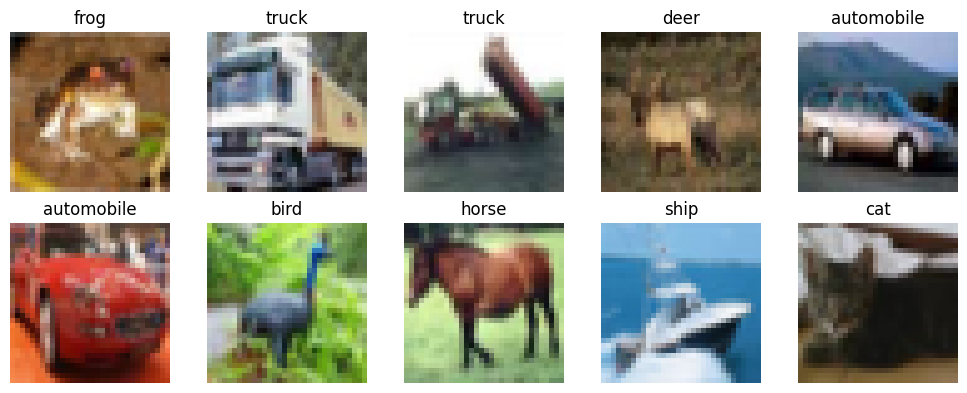

In [8]:
# A few sample images with labels
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train_flat[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

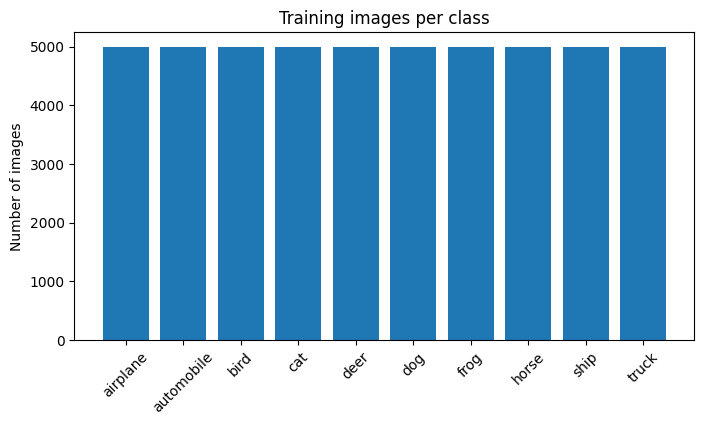

In [9]:
# Bar plot of images per class
plt.figure(figsize=(8,4))
counts = [train_counts[i] for i in range(10)]
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.ylabel("Number of images")
plt.title("Training images per class")
plt.show()

- This is a keras dataset cifar, consisting of 60,000 images and its classifications labels (0-9). These are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. The dataset is split to training data consisting of 50,000 images and to testing data containing of 10,000 images. Images are RGB images of 32x32 pixels. The classes in the dataset are perfectly distributed, with 5,000 images per each class.

step 3 : preprocessing the data

3.1 normalization

In [10]:
# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0


3.2 converting Numpy arrays to Tensorflow dataset

- as we are using v6e-1 TPU it's recommended to  convert the NumPy arrays into TensorFlow datasets.


In [11]:
import tensorflow as tf

BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

3.3 Shuffle, batch, prefetch


- TPUs are extremely fast, but: If data is not ready → TPU waits → wasted performance

- Instead of loading everything at once, TensorFlow:Feeds data batch by batch, Prepares the next batch while the model is training, Keeps the TPU/GPU busy



this will :

- Shuffle : Randomly mixes training samples every epoch that will avoid learning order-specific patterns ( instead of cat , cat , cat , car, car .. ) , ( car , cat , deer, car , cat dog .. ), without shuffeling , model might overfit and generalization is worse ( we don't suffle the test set because order doesnot matter )

- Batch : Groups individual samples into mini-batches.Train efficiently on TPU/GPU, we choose batch size =256 because TPU s are made for big size batches between 128 and 512

- Prefetch: Prepares the next batch while the model is training on the current one. Never let the accelerator sit idle ( maximum hardware usage )

In [12]:
train_ds = (
    train_ds
    .shuffle(buffer_size=50000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


Step 4 :  Build the models

4.1 Baseline model

Simple architecture:

- 3 convolution layers with filters (32, 64 , 128)

- activation function : ReLu

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

In [13]:
#build the model
with strategy.scope():
    Base_model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        # Conv block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        # Conv block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        # Conv block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        # Classifier
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    Base_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Inspect the model
Base_model.summary()

# Train the model
EPOCHS = 25
history = Base_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3139 - loss: 1.8682 - val_accuracy: 0.4934 - val_loss: 1.3862
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5309 - loss: 1.3140 - val_accuracy: 0.5814 - val_loss: 1.1799
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6066 - loss: 1.1138 - val_accuracy: 0.6409 - val_loss: 1.0222
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6609 - loss: 0.9690 - val_accuracy: 0.6401 - val_loss: 1.0443
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6905 - loss: 0.8831 - val_accuracy: 0.6914 - val_loss: 0.8938
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7179 - loss: 0.8149 - val_accuracy: 0.6902 - val_loss: 0.9023
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7458 - loss: 0.7382 - val_accuracy: 0.7056 - val_loss: 0.8667
Epoch 8/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7604 - loss: 0.6923 - val_accu

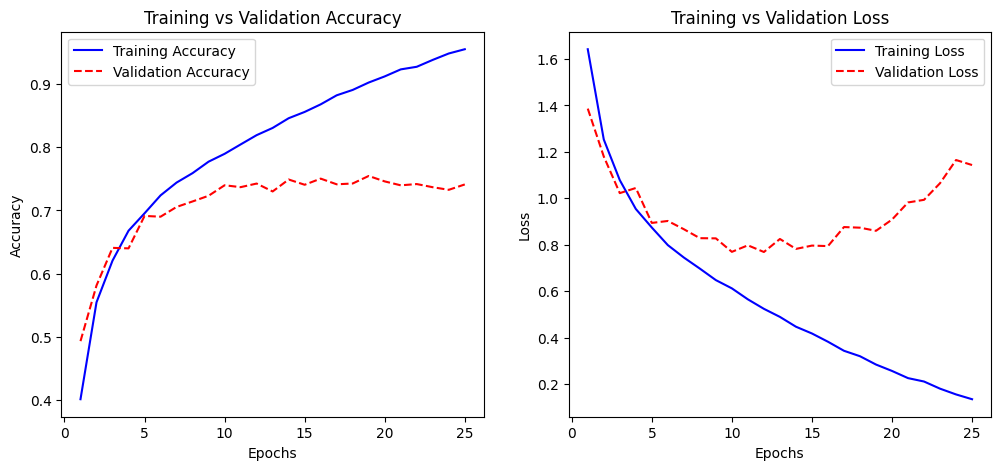

In [14]:
import matplotlib.pyplot as plt

# Get metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


- accuracy: 0.9510 - loss: 0.1445 - val_accuracy: 0.7412 - val_loss: 1.1432
- Training accuracy is very high, but validation accuracy is low → overfitting.

- Validation loss is much higher than training loss → confirms overfitting.

let's fix this by a batch normalization

4.2 Baseline model with batch normalization

Architecture :
- 3 convolution layers with filters (32, 64 , 128)

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

why this emprovement matters ?
- in the normal back and forward propagation the output of layers keep changing making it hard for the network to learn

- the batch normalization comes between the conv layer (without activation function) and the activation function , so that it prepares the input data for each layer befor the activation

- the input preparation is to cumpute the mean and variance through mini batches and then normalize them mean = 0 and variance =1 and then shift and scale them using learned factors. the layers will now  see the data in a stable range ( this will give better and faster learning )

- calculating the mean and variance from different batches instead of the hole dataset, this randomness will add noise to the activation function which reduces overfitting

In [15]:
with strategy.scope():
    model_bn = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        # Block 1
        layers.Conv2D(32, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Classifier
        layers.Flatten(),
        layers.Dense(128, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(10, activation='softmax')
    ])

    model_bn.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

model_bn.summary()

#train the model
EPOCHS = 25
history_bn = model_bn.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4993 - loss: 1.4224 - val_accuracy: 0.2121 - val_loss: 2.9664
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7107 - loss: 0.8328 - val_accuracy: 0.4028 - val_loss: 1.8541
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7824 - loss: 0.6394 - val_accuracy: 0.5802 - val_loss: 1.2126
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8245 - loss: 0.5175 - val_accuracy: 0.5605 - val_loss: 1.4440
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8636 - loss: 0.4119 - val_accuracy: 0.6778 - val_loss: 1.0281
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8956 - loss: 0.3209 - val_accuracy: 0.7017 - val_loss: 0.9341
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9237 - loss: 0.2471 - val_accuracy: 0.7033 - val_loss: 0.9643
Epoch 8/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9465 - loss: 0.1855 - val_acc

In [1]:
type(model_bn)

NameError: name 'model_bn' is not defined

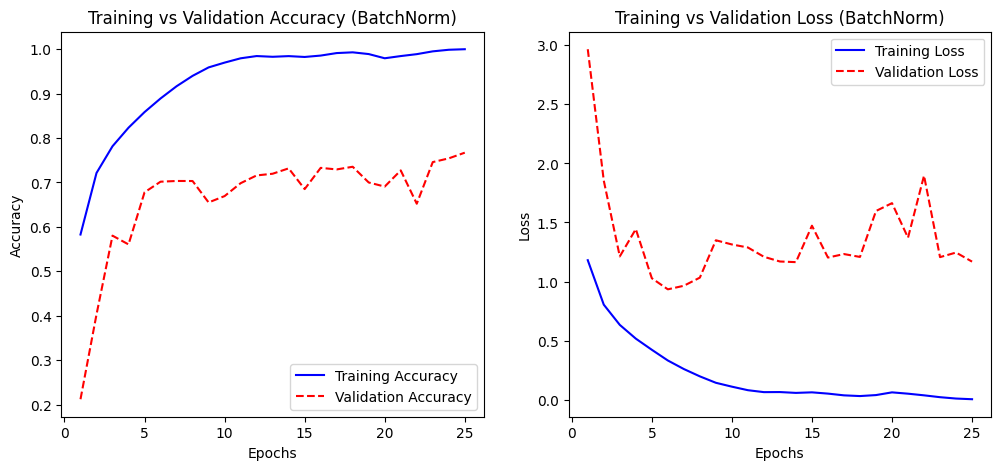

In [16]:
import matplotlib.pyplot as plt

acc = history_bn.history['accuracy']
val_acc = history_bn.history['val_accuracy']
loss = history_bn.history['loss']
val_loss = history_bn.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (BatchNorm)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss (BatchNorm)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


- accuracy: 0.9997 - loss: 0.0050 - val_accuracy: 0.7670 - val_loss: 1.1686
- Training accuracy improved → the network learned faster thanks to Batch Normalization
- Validation accuracy is still much lower → overfitting persists
- Validation loss > training loss → confirms overfitting

let's keep this model and artificially change the dataset by a data augmentation

4.3 model batchnormalization with data augmentation

Architecture :
- 3 convolution layers with filters (32, 64 , 128)

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

- Data augmentaion 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)



# Use it with model_bn
EPOCHS = 25
history_bn_aug = model_bn.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.6698 - loss: 1.3310 - val_accuracy: 0.6326 - val_loss: 1.3999
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7428 - loss: 0.7487 - val_accuracy: 0.7444 - val_loss: 0.7597
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7619 - loss: 0.6838 - val_accuracy: 0.6842 - val_loss: 0.9962
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7794 - loss: 0.6279 - val_accuracy: 0.7347 - val_loss: 0.8905
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.7913 - loss: 0.6018 - val_accuracy: 0.7252 - val_loss: 0.8719
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8011 - loss: 0.5668 - val_accuracy: 0.7676 - val_loss: 0.7208
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8014 - loss: 0.5629 - val_accuracy: 0.7276 - val_loss: 0.8412
Epoch 8/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8056 - loss: 0.5554 - val_accurac

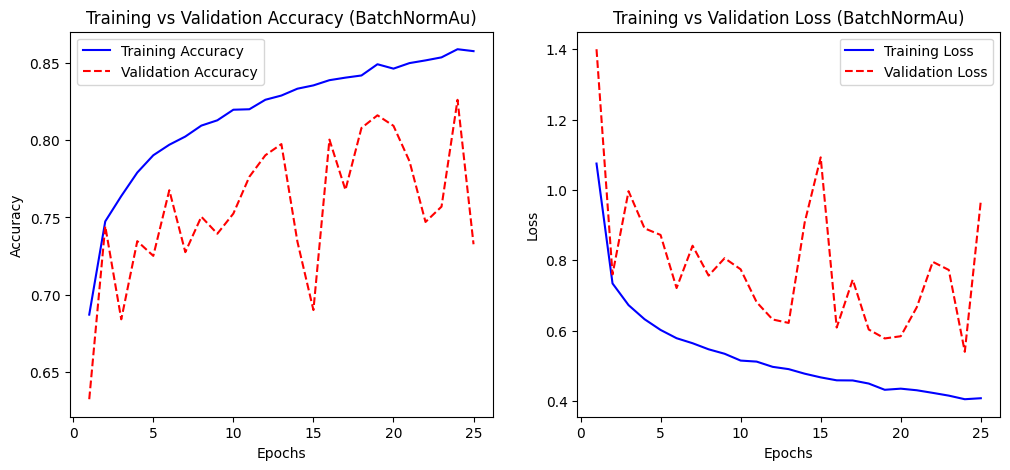

In [18]:
import matplotlib.pyplot as plt

acc = history_bn_aug.history['accuracy']
val_acc = history_bn_aug.history['val_accuracy']
loss = history_bn_aug.history['loss']
val_loss = history_bn_aug.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (BatchNormAu)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss (BatchNormAu)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


- accuracy: 0.8600 - loss: 0.4002 - val_accuracy: 0.7327 - val_loss: 0.9686
- Training accuracy < 0.9 → the model is not overfitting aggressively anymore thanks to data augmentation.

- Validation accuracy 0.71 → slightly lower than training accuracy confirmes the overfitting is reduced

Validation loss peaked around epoch 17 and then converged -> let's use the eraly stoping to have the max performance of this model

3.4 model with batch normalization , data augmentation and earlystoping

Architecture : 
- 3 convolution layers with filters (32, 64 , 128) 

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

- Data augmentaion 

- Early stopping

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_bn_aug_es = model_bn.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=50,               # set a large max_epochs
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8604 - loss: 0.3961 - val_accuracy: 0.7966 - val_loss: 0.6297
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8643 - loss: 0.3902 - val_accuracy: 0.7964 - val_loss: 0.6498
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.8652 - loss: 0.3848 - val_accuracy: 0.7141 - val_loss: 1.0598
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8679 - loss: 0.3787 - val_accuracy: 0.8167 - val_loss: 0.5550
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8725 - loss: 0.3624 - val_accuracy: 0.7914 - val_loss: 0.6750
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8710 - loss: 0.3682 - val_accuracy: 0.8105 - val_loss: 0.5916
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8709 - loss: 0.3623 - val_accuracy: 0.8180 - val_loss: 0.5693
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8743 - loss: 0.3563 - 

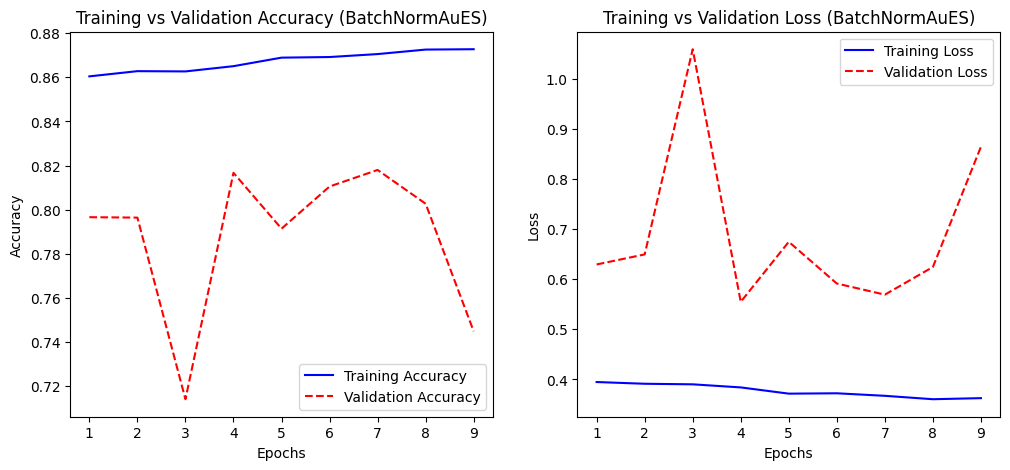

In [20]:
import matplotlib.pyplot as plt

acc = history_bn_aug_es.history['accuracy']
val_acc = history_bn_aug_es.history['val_accuracy']
loss = history_bn_aug_es.history['loss']
val_loss = history_bn_aug_es.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (BatchNormAuES)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss (BatchNormAuES)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


- Early stopping would likely trigger soon (epoch 10)

- Validation accuracy jumped from 0.71 to 0.81 → data augmentation is clearly helping generalization

- Validation loss decreased to 0.5993 → less overfitting

we still want to improve accuracy , let's try a dropout in the next model

3.5 model with batch normalization , data augmentation , earlystoping and dropout

Architecture : 
- 3 convolution layers with filters (32, 64 , 128) 

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

- Data augmentaion 

- Early stopping

- Dropout ( O.2 _ 0.3 _ 0.4 ) respectively after each conv layer and (0.4) after the dense layer 

In [21]:

# Define EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Build the model
with strategy.scope():
    model_bn_drop_Au_ES = models.Sequential([
        # First Conv block
        layers.Conv2D(32, (3,3), padding='same', activation=None, input_shape=(32,32,3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # Second Conv block
        layers.Conv2D(64, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        # Third Conv block
        layers.Conv2D(128, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        # Classifier
        layers.Flatten(),
        layers.Dense(128, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])

    model_bn_drop_Au_ES.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
history_bn_drop_Au_ES = model_bn_drop_Au_ES .fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.2920 - loss: 2.0530 - val_accuracy: 0.0999 - val_loss: 3.5436
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.4478 - loss: 1.5117 - val_accuracy: 0.2292 - val_loss: 2.6688
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.4984 - loss: 1.3862 - val_accuracy: 0.4747 - val_loss: 1.4229
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5398 - loss: 1.2845 - val_accuracy: 0.4912 - val_loss: 1.5271
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5664 - loss: 1.2158 - val_accuracy: 0.6067 - val_loss: 1.0814
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5881 - loss: 1.1552 - val_accuracy: 0.6273 - val_loss: 1.0541
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.6052 - loss: 1.1209 - val_accuracy: 0.4480 - val_loss: 1.8077
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.6172 - loss: 1.0728 - 

- Dropout rates were too high (0.3–0.4) → the model couldn’t learn effectively

- model underfitting now (training accuracy only 0.60)

let's Remove the dropout for now stick with the Model_BN_AU_ES which gave 0.81 validation accuracy and try to improve accuracy with slightly increasing Conv filters (32→64→128→256)

3.6 model with batch normalization , data augmentation, early stoping and more conv layers

Architecture : 
- 3 convolution layers with filters (64 , 128, 256) 

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 256 Dense

- Optimizer = adam

- Data augmentaion 

- Early stopping


In [23]:

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Build deeper model
with strategy.scope():
    model_bn_filt_Au_ES = models.Sequential([
        # Conv Block 1
        layers.Conv2D(64, (3,3), padding='same', activation=None, input_shape=(32,32,3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Conv Block 2
        layers.Conv2D(128, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Conv Block 3
        layers.Conv2D(256, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(10, activation='softmax')
    ])

    model_bn_filt_Au_ES.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


In [24]:
history_bn_more_filters = model_bn_filt_Au_ES.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.4651 - loss: 1.5161 - val_accuracy: 0.1373 - val_loss: 3.2554
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.6568 - loss: 0.9674 - val_accuracy: 0.4480 - val_loss: 1.5759
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.7135 - loss: 0.8225 - val_accuracy: 0.7088 - val_loss: 0.8369
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.7407 - loss: 0.7386 - val_accuracy: 0.6159 - val_loss: 1.2616
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.7593 - loss: 0.6889 - val_accuracy: 0.5511 - val_loss: 1.4620
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.7791 - loss: 0.6314 - val_accuracy: 0.6836 - val_loss: 0.9568


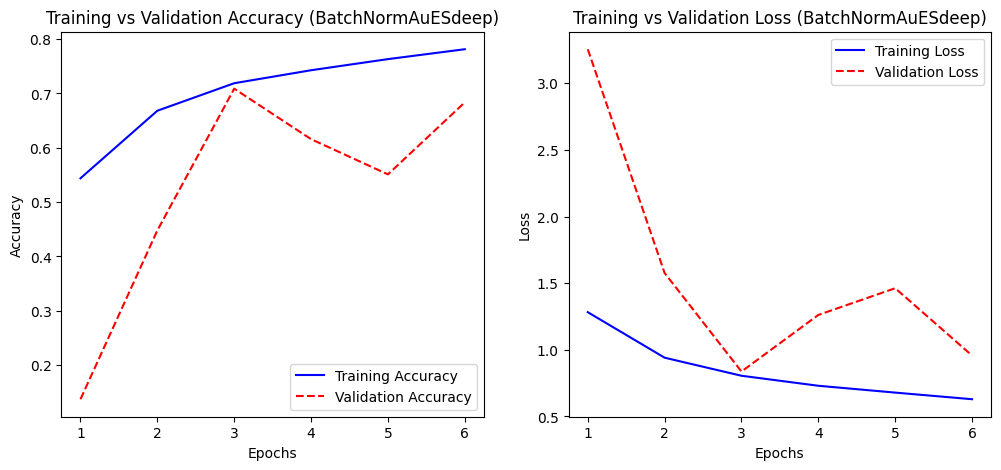

In [25]:
import matplotlib.pyplot as plt

acc = history_bn_more_filters .history['accuracy']
val_acc = history_bn_more_filters.history['val_accuracy']
loss = history_bn_more_filters.history['loss']
val_loss = history_bn_more_filters.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (BatchNormAuESdeep)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss (BatchNormAuESdeep)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- performance got worse after adding more conv layers and neurons in the fully connected layer
- CIFAR-10 images are small (32×32) → very deep models may not effectively learn more features

let's ignore this change and come back to the less deeper model with data augmentation early stoping and batch normalization and take it as a base while playing on the learning rate

3.7 model with batch normalization data augmentation early stoping and optimized learning rate

Architecture : 
- 3 convolution layers with filters (32, 64 , 128) 

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

- Data augmentaion 

- Early stopping

- reduced learning rate (0.0005)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce LR by half
    patience=3,       # wait 3 epochs before reducing
    min_lr=1e-5,      # lower bound
    verbose=1
)


In [27]:
history_lr = model_bn.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8691 - loss: 0.3654 - val_accuracy: 0.8016 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8699 - loss: 0.3652 - val_accuracy: 0.8116 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8728 - loss: 0.3613 - val_accuracy: 0.7789 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8715 - loss: 0.3702 - val_accuracy: 0.8076 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8729 - loss: 0.3564 - val_accuracy: 0.8163 - val_loss: 0.5921 - learning_rate: 0.0010
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.8757 - loss: 0.3523 - val_accuracy: 0.7983 - val_loss: 0.6446 - learning_rate: 0.0010
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8788 - l

- Model acheived 0.825 val accuracy with no overfitting , good generalization and the minimum loss so far
- Model was learning fast but overshooting good minimums that's why optimizing lr worked well , that's why i decide to reduce lr one more time in the next trial

3.8 model with batch standardization , data augmentation , earlystoping , 2 times reduced lR

Architecture : 
- 3 convolution layers with filters (32, 64 , 128) 

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = adam

- Data augmentaion 

- Early stopping

- reduced learning rate ( 0.000125)

In [28]:

# EarlyStopping must allow LR to reduce again
early_stop_lr2 = EarlyStopping(
    monitor='val_loss',
    patience=6,                 # > reduce_lr patience
    restore_best_weights=True
)

# Same LR scheduler
reduce_lr_lr2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# Continue training (same model, same weights)
history_lr_phase2 = model_bn.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=80,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_lr2, reduce_lr_lr2]
)


Epoch 1/80
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8882 - loss: 0.3186 - val_accuracy: 0.8002 - val_loss: 0.6484 - learning_rate: 5.0000e-04
Epoch 2/80
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8914 - loss: 0.3065 - val_accuracy: 0.8310 - val_loss: 0.5455 - learning_rate: 5.0000e-04
Epoch 3/80
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.8944 - loss: 0.2971 - val_accuracy: 0.8460 - val_loss: 0.4928 - learning_rate: 5.0000e-04
Epoch 4/80
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.8965 - loss: 0.2939 - val_accuracy: 0.8259 - val_loss: 0.5706 - learning_rate: 5.0000e-04
Epoch 5/80
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8979 - loss: 0.2911 - val_accuracy: 0.8364 - val_loss: 0.5099 - learning_rate: 5.0000e-04
Epoch 6/80
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8976 - loss: 0.2892
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - ac

- the val accuracy achieved 0.84 and the loss got lower to reach 0,49

*   Listeneintrag
*   Listeneintrag


- no overfitting no underfitting the gap between train and val is 0.6
-lr rate is reduced to 1.25e-4

we might have reached the ceilling for a from scratch model but there is one more experience to try , changing the adam optimizer .. lets do it

3.9 model with batch standardization , data augmentation , earlystoping , lr reduced, and SGD optimizer

- we cant build on the last model because it's LR doesn't match with sgd needs. we will generate a new higher lr for sgd

Architecture : 
- 3 convolution layers with filters (32, 64 , 128) 

- activation function : ReLu

- batch normalization for each convolution layer 

- Maxpooling 2D  for each layer

- fully connected layer with 128 Dense

- Optimizer = SGD

- Data augmentaion 

- Early stopping

- reduced learning rate ( 0.00001)

In [29]:
from tensorflow.keras.optimizers import SGD

optimizer_sgd = SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)


In [30]:
model_bn.compile(
    optimizer=optimizer_sgd,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:


early_stop_sgd = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr_sgd = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

In [32]:
history_sgd = model_bn.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_sgd, reduce_lr_sgd]
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.8574 - loss: 0.4197 - val_accuracy: 0.8040 - val_loss: 0.6427 - learning_rate: 0.0100
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8842 - loss: 0.3271 - val_accuracy: 0.7728 - val_loss: 0.7661 - learning_rate: 0.0100
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8895 - loss: 0.3149 - val_accuracy: 0.8367 - val_loss: 0.5253 - learning_rate: 0.0100
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8894 - loss: 0.3066 - val_accuracy: 0.7630 - val_loss: 0.7987 - learning_rate: 0.0100
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8924 - loss: 0.3041 - val_accuracy: 0.7499 - val_loss: 0.8566 - learning_rate: 0.0100
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8958 - loss: 0.3001
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.8958





- val_accuracy   = 0.85 with
- learning rate evolution 0.01 → 0.001 → 0.0001 → 0.00001
- Train vs Val gap is small
- Validation loss is still decreasing
- we have a better performance we can conclud that SGD generalizes  better than Adam

now let's have some inspiration from ResNet architecture to improve the model in the next trial

3.10 ResNet inspiration model


why this Architecure ?
- we already experimented that making the model deeper by adding layers without skiping connections didn't help
- ResNet (  CNN + skip (residual) connections) might helps because it allows to prevent degradation when adding layers

- our current architecure looks like : Conv → BN → ReLU → Conv → BN → ReLU →


- ResNet Architecture looks more like :
- Initial Conv (32 filters) → Residual Block ×2 (32 filters)→ Residual Block ×2 (64 filters) →Residual Block ×2 (128 filters) →Global Average Pooling →Dense(10)

- This is much better than:Deeper Sequential CNN with Bigger Dense layers

- in this experience we will build a model with Data augmentation, Batch Normalization, SGD ,ReduceLROnPlateau ,EarlyStopping and residual blocks instead of sequential CNN

A- create a residual block

In [33]:
def residual_block(x, filters, downsample=False):
    shortcut = x

    strides = 2 if downsample else 1

    # First convolution
    x = layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions if needed
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x


B-Build a Small ResNet

In [34]:
from tensorflow.keras import Model, Input
def build_small_resnet(input_shape=(32,32,3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Residual blocks
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    x = residual_block(x, 64, downsample=True)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)


C- Compile with SGD

In [35]:
from tensorflow.keras.optimizers import SGD
with strategy.scope():
    resnet_model = build_small_resnet()

    optimizer = SGD(
        learning_rate=0.01,
        momentum=0.9,
        nesterov=True
    )

    resnet_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


D- early stopping and LR reduction

In [36]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5,
    verbose=1
)


E- train with data augmentation

In [38]:
history_resnet = resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=256),
    epochs=120,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/120


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.3540 - loss: 1.7821 - val_accuracy: 0.1072 - val_loss: 3.6371 - learning_rate: 0.0100
Epoch 2/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.5564 - loss: 1.2319 - val_accuracy: 0.3703 - val_loss: 1.9331 - learning_rate: 0.0100
Epoch 3/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.6322 - loss: 1.0381 - val_accuracy: 0.5514 - val_loss: 1.4613 - learning_rate: 0.0100
Epoch 4/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.6764 - loss: 0.9178 - val_accuracy: 0.6435 - val_loss: 1.0209 - learning_rate: 0.0100
Epoch 5/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.7141 - loss: 0.8154 - val_accuracy: 0.6243 - val_loss: 1.1007 - learning_rate: 0.0100
Epoch 6/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 235ms/step - accuracy: 0.7362 - loss: 0.7528 - val_accuracy: 0.6862 - val_loss: 0.9508 - learning_rate: 0.0100
Epoch 7/120
196/196 ━━━━━━━━━━━━━━━━━━━━ 46s 236ms/step - accuracy: 0.7562 -

- using the ResNet architecture with residual blocks increased the accuarcy from 0.85 to O.88

- no under or over fitting

- Skip connections did exactly what they are meant to do, Higher training accuracy , Lower validation loss , Better generalization

- The model was able to Go deeper, Learn more expressive features ,Avoid degradation

- I decide to stop the training at this level because accuracy is very high and Lr is at its lowest level as well as the loss value

- what i learned ?